In [1]:
#|default_exp sgd

# Accelerated SGD

In [1]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder


In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

To summarize what we've got: `metrics` callback, `astats` ActivationStats on the GeneralRelu; 
`cbs` callbacks are DeviceCB to put it on Cuda or CPU, 
the `metrics`, the `ProgressCB` bar, and `astats`.
The activation function `act_gr` is `GeneralRelu` with `leak=0.1` leakiness and `sub=0.4` subtraction.
The inner weights `iw` which we need to tell it about how leaky they are.
If we're doing a `LRfinder` we've got a different set of callbacks, `lrf_cbs`.

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Optimizers

### SGD

Let's create our own SGD class.
An SGD class needs to know what parameters to optimize.
The `module.parameters` method returns a generator so we use `list()` to turn that into a list.
We need to know the learning rate `lr`, and the weight decay `wd`.
We also want to keep track of what batch number `i` are we up to.

An Optimizer has a `step()` and a `zero_grad()`.
`step()` uses `with torch.no_grad()`, because this is not part of the thing that we're optimizing.
This is the optimization itself through each tensor of parameters.
We do a step of the the regularizer, `.reg_step`, and of the optimizer `.opt_step`.
And keep track of the batch number `.i +=1` we're up to.<br>
The `opt_step` subtract from the parameter its `.grad` times the `lr`. 
(that's an SGD optimization step)
The `zero_grad` goes through each parameter and `zero_()` it.

In [6]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

Consider the difference between *weight decay* and *L2 regularization*:
``` python
weight -= lr*wd*weight
```
...vs...
``` python
weight.grad += wd*weight
```

Regularization: weight decay (L2 regularization) says let's add the square of the weights 
to the loss function.
We care about the derivative, that is equal to the derivative of the loss 
plus the derivative of the sum of 2W.
We can do weight decay by taking our gradients and adding `wd * weights`.
Since that's part of the gradient then in the optimization step that's
using the gradient and it's subtracting out `grad * lr`.

Because we're just doing `p.grad * self.lr` and the `p.grad` update is just to add `wd*weight`,
we can skip updating the gradients, and instead directly update the weights to subtract the `lr*wd*weight`.
They would be mathematically identical, and that is what we've done in `reg_step`.
If we've got `self.wd != 0` then just take `p *=1 - self.lr*self.wd` which is the same.
That's why the regularization is inside SGD.

Let's create a trained learner.
It's a learner with a training callback built-in.
We're going to set the optimization function to be the `SGD` we just wrote,
and we'll use the `BatchNorm` model with the weight initialization we've used before.
If we train it then this should give us the same results as before.

In [7]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.767,0.661,0,train
0.815,0.508,0,eval
0.840,0.436,1,train
0.840,0.442,1,eval
0.857,0.389,2,train
0.854,0.403,2,eval


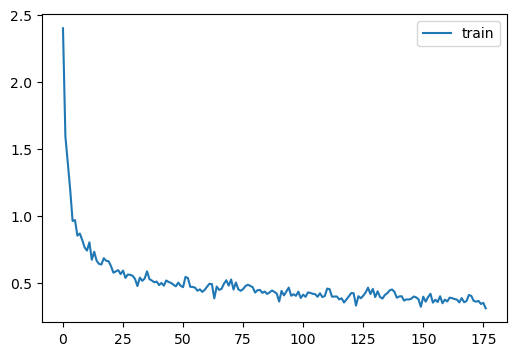

In [8]:
learn.fit(3)

Finished running, got .859 accuracy, and we're able to train at our high lr of 0.4.

### Momentum

Let's add momentum. 
We had a hacky momentum learner before.
Momentum should be in an Optimizer. <br>
First let's review what momentum actually is.
Let's create some data: 
Our X's are going to be 100 equally spaced numbers from -4 to 4.
Our y's are just going to be minus our X's divided by 3 squared plus some randomization.

In [9]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

We show what momentum looks like for a range of different levels (`betas = [0.5,0.7,0.9,0.99]`) of momentum.
First is `beta=0.5`.
We do a scatter plot of our x's and y's, the blue dots.
and then we're going to go through each of the Y's.
We're going to do a lerp.
We update the previous average (which will start at zero) with `avg = beta*avg + (1-beta)*yi`,
and append it to the `res` red line.
We do that for all the data points and then plot them.
The red line becomes less bumpy because each one is half this exact Dot (data point) 
and half of whatever the red line previously was.
This is an *exponentially weighted moving average* (We could have implemented this using lerp).

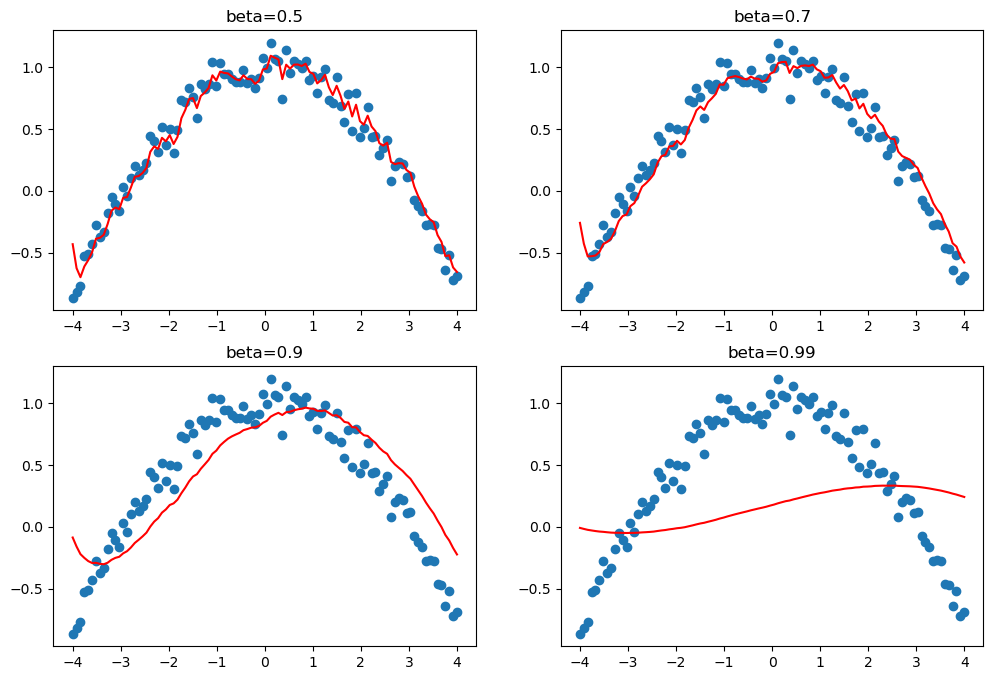

In [10]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

As the beta gets higher it's saying do more of wherever the red line used to be
and less of where this particular data point is.
Hence, when we have *outliers* the red line doesn't jump around as much.
But, if momentum gets too high, it doesn't follow what's going on, it's way behind.
Momentum is always partially responding to how things were many batches ago.
Even at `beta=0.9`, the red line is offset to the right:
it's taking it a while for it to recognize that things have changed.
Each time 0.9 of it is where the red line used to be and only 0.1 of it is what this data point indicates.
Momentum is useful when a loss function is very bumpy, we want to be able to follow the actual curve.
Using momentum we don't quite get that, but we've get a version that is offset, hopefully following the average of those directions.

`Momentum` will inherit from `SGD` and we override the definition of the `opt_step`.
When we create a momentum object we tell it what momentum `mom` we want or default it to `mom=0.9`.
Then in the optimization step for each parameter `p` in our model 
(each layer's weights in each layer's biases),
we'll find out for that parameter `p` if we ever stored away its moving average of gradients before.
If we haven't then we'll set them to zero initially.
`if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)`
And then we will do our moving average of exponentially weighted gradients 
is equal to whatever it used to be times the momentum, plus `p.grad*(1-self.mom)`
That's doing the `leap`.
Then we're going to do as the SGD update step,
but instead of multiplying by `p.grad` we're multiplying it by `p.grad_avg`.
We invented a new attribute, `.grad_avg`, putting it inside the parameter tensor and use it to store
the exponentially weighted moving average of gradients for that particular parameter.
As we Loop through the parameters we don't have to do any special work to get access to that.

NB: JH decided not to do the initializing of `p.grad_avg` to zeros.
If we initialize to zeros then (later) the initial denominator will be 0 plus Epsilon,
and the initial LR will be very high.
Instead, it used `torch.zeros_like(p.grad)`, i.e., whatever the first minibatch gradient is.
This is a useful trick for using RMS prop.

In [11]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

Interestingly we can hike the LR up to 1.5, because we're not getting these huge bumps anymore.

In [12]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.791,0.584,0,train
0.849,0.412,0,eval
0.873,0.351,1,train
0.866,0.365,1,eval
0.887,0.311,2,train
0.877,0.346,2,eval


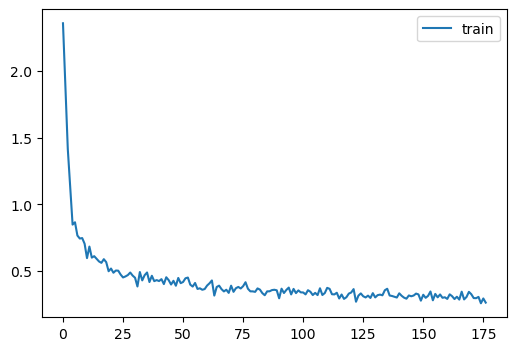

In [13]:
learn.fit(3)

Previously we got .85 (we've gone back to our 1024 batch size and 3 epochs in a constant LR) and we've gone up to .87.
A loss function that is smooth improved things.

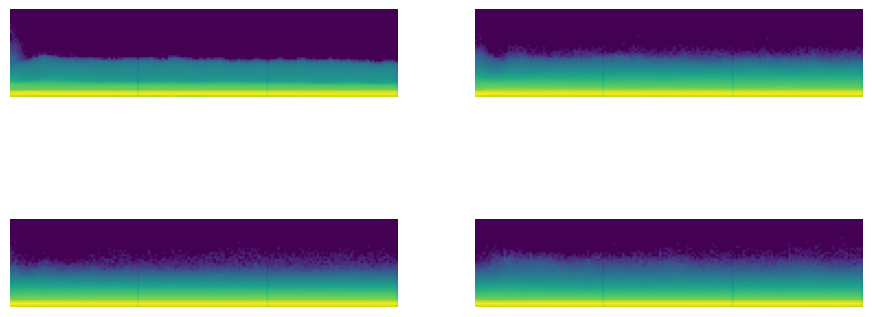

In [14]:
astats.color_dim()

The colordem plot is the smoothest we've seen.
It's a bit different to the momentum learner because the momentum learner didn't have a `1- ` part.
It wasn't lurping it was always including all of the Grad `+` a bit of the momentum part.
This is a different better approach, we've got a smooth result.

Q: Don't we get a similar effect of the smoothness if we increase the batch size?
A: Yes we do. But if we just increase the batch size we're giving it less opportunities to update.
Having a really big batch size is not great.
*LaCunn* thinks that the ideal batch size, if we can, is 1, but it's just slow.
We want to have as many opportunities to update as possible.
Some people are trying to create large batch sizes which doesn't make any sense.
We want the smallest batch size we can get away, to give it the most chances to update.

Here we've got good results despite using only 3 epochs with a very large batch size.

Adding momentum can be a bit aggressive for some finicky architectures.
`RMSprop` can be a good way to get reasonably fast optimization of a finicky architecture.
For example, *efficientNet* ?? is an architecture which trained best with RMSprop.

### RMSProp

RMSprop updates the optimization step using something similar to momentum.
Instead of lerping on the `p.grad`, we `lerp` on `p.grad**2` (squared).
For consistency, we call it `sqr_mom`, but is just the multiplier.
A large grad squared indicates a large variance of gradients.
We divide by `(p.sqr_avg.sqrt() + self.eps` (the square root of that plus $\epsilon$).
We put the $\epsilon$ *outside* the square root, it does make a difference, so be careful as to how $\epsilon$ is being interpreted.
This is a very common cause of confusion and errors.
We're dividing the gradient by the the amount of variation: `p.grad/(p.sqr_avg.sqrt() + self.eps)`
(The square root of the moving average of gradient squared.)
If the gradient has been moving around a lot, we don't know what it is, so we shouldn't do a very big update.
If the gradient is the same all the time, then we're confident about it, we do want a big update.

In [15]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

Because we divide by a small number, we have to decrease the learning rate  to `lr=3e-3`.

accuracy,loss,epoch,train
0.758,0.682,0,train
0.823,0.490,0,eval
0.846,0.424,1,train
0.845,0.428,1,eval
0.864,0.373,2,train
0.853,0.398,2,eval


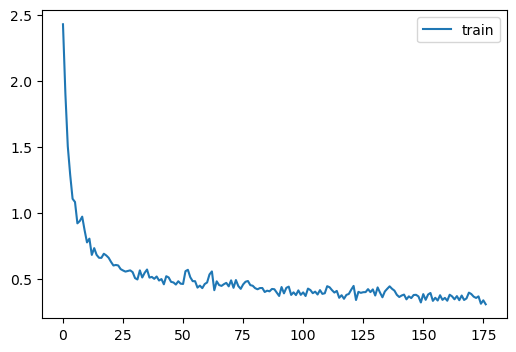

In [16]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

The colorful Dimension plot looks very nice.

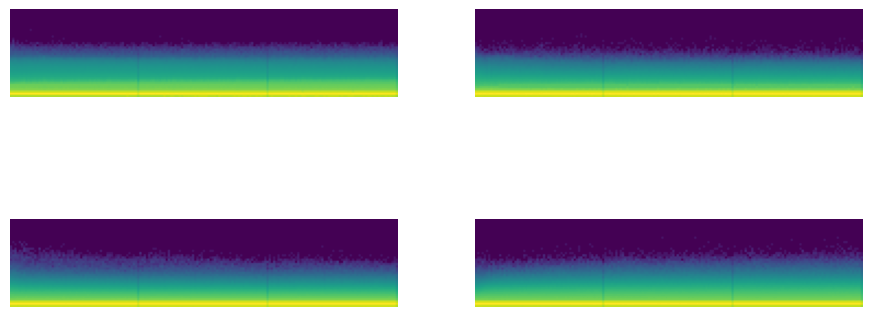

In [17]:
astats.color_dim()

### Adam

`Adam` is `RMSprop` plus `momentum` together.
`Beta1` is the momentum from the momentum Optimizer, `beta2` is the momentum for the squares from the RMSprop optimizer.
We store those and because RMSprop we need the Epsilon `eps`.
We store the gradient average `avg` and the square average, `sqr_avg`, and then we're going to do our lerping.
We use `torch.zeros_like` as starting values for `avg` and `sqr_avg`, and then we unbias the, e.g.:
```Python
p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
```
For the very first minibatch if we have zero here being lurped with the gradient,
then the first minibatch will be closer to zero than it should be.
But we know how much closer it should be to zero, which is `self.beta1` times closer (in the first minibatch).
For the `i` minibatch it'll be  `(self.beta1**(self.i+1))`.
That's why we had `self.i` our `SGD`, keeping track of how many batches were up to, to do unbiasing of the average.
Unbiased versions matters for the first few minibatches otherwise it would be too close to zero.

In [18]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

We would expect the learning rate to be similar to what RMSprop needs because we're
doing that same division so we actually do have the same learning rate here.
We're up to .87 accuracy, less good than momentum.
We can fiddle around momentum (we had 0.9), values of beta2 beta1, and see if we can beat the momentum version.

accuracy,loss,epoch,train
0.787,0.593,0,train
0.842,0.435,0,eval
0.867,0.370,1,train
0.863,0.374,1,eval
0.881,0.327,2,train
0.872,0.353,2,eval


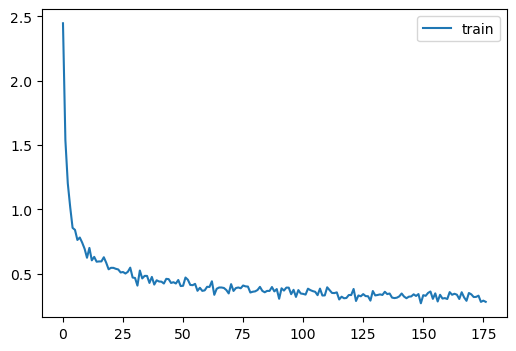

In [19]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

## Schedulers

Let's see how we can do our own learning rate scheduling or annealing within the mini AI framework.

We've already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

When we implemented `LRfinder` (Notebook 09_Learner) we saw how to create something that adjusts the learning rate.
We had to go through the optimizers parameter groups and in each group set
the learning rate to times equals some multiplayer.
```Python
for g in learn.opt.param_groups: g['lr'] *= self.lr_mult
```
That was for the learning rate finder.

Instead we look inside the torch `lr_scheduler` module, and see what's defined in there.
We can hit Dot Tab and see what's in there.
Another way is to use `dir(lr_scheduler)` because it tells us everything inside a python object.
`lr_scheduler` is a module object, so it tells us all the stuff in the module.
When we use the dot version tab it doesn't show stuff that starts with an `_` because that is considered private.

In [20]:
dir(lr_scheduler)[:10]

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR']

We see that the items that start with a capital and then a small letter look like the things we care about.
We probably don't care about those that start with `_`, etc.
We can just do a list comprehension that checks that the first letter is an uppercase and the second letter is lowercase 
and then join those all together with a space.
This is a list of all of the schedulers that Pytorch has available...
(JH couldn't find such a list on the pytorch website documentation).
A handy thing to have available.

In [21]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

From the various schedules we can use, lets experiment with `CosineAnnealingLR`.
NB: Pytorch schedulers work with Pytorch optimizers not with custom SGD class.
Pytorch optimizers have a slightly different API.
We might learn how they work, so we need an Optimizer.
An easy way to grab an Optimizer is to create a learner and pass in the 
`SingleBatchCB` callback that we created in notebook 9.
```Python
class SingleBatchCB(Callback):
    order=1
    def after_batch(self, learn): raise CancelFitException()
```
It cancels the fit, so it just does one batch.

In [22]:
from fastcore.basics import Self as X

In [23]:
' '.join(filter(X[0].isupper() and X[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR bisect_right inf math types warnings weakref wraps'

And we could `fit` and from that we've now got a learner and an optimizer.

In [24]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

We can do the same thing to the Optimizer to see what attributes it has.
or just read the Pytorch documentation. 
As expected it's got the `step` and the `zero_grad`. 

In [25]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups state state_dict step zero_grad'

Or we can just type opt.
Pytorch optimizers have a "repra"? which means we can just type it in 
hit shift enter and we can see the information about it this way.

In [26]:
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

The default Optimizer for the `TrainLearner` was set to `optim.sgd.SGD`.
The SGD Optimizer has parameter groups.

Let's grab all of our parameters. It is  a generator, so we have to turn it into an iterator 
and call next to give us our first parameter.
We can check the `.state` of the optimizer, which is a dictionary whose keys are parameter tensors.
Normally we use numbers or strings as keys, but we can use tensors as keys.
Here `param` is a tensor parameter, a tensor which it `requires_grad`.
We're actually using that to index into the `state` dictionary where the keys are parameters.

In Miniai we had each parameter, we stored as attributes: its state, the average of the gradients 
or the exponentially weight of moving average gradients and of squared averages.
Pytorch doesn't store them as attributes, but instead the optimizer has a dictionary 
where we can look up using a parameter as key.

In [28]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

That returns the state in `st`.

In [29]:
st

{'momentum_buffer': None}

This is the exponentially weighted moving averages and because we haven't done any
training yet and because we're using non-momentum STD SGD it's none.
That's how it would be stored by Pytorch, which works as well.

In [30]:
len(opt.param_groups)

1

In SGD we stored the parameters directly but in Pytorch those parameters can be put into groups.
Since we haven't put them into groups the length of `param_groups` is one,
and that group (0) contains all of our parameters.

In [31]:
pg = opt.param_groups[0]

`pg` is a dictionary it's a parameter group.
`list()` gives us back the keys, a quick way of finding out all the keys in a dictionary.
We can see all the parameters in the group: the hyper parameters, the learning rate, the momentum weight, Decay etc.

In [32]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach']

Q: isn't indexing by a tensor just like passing a tensor argument to a method?
A: no it's not the same. This is how the Optimizer stores state about the parameters.

Let's look at how schedulers work. 
Let's create a `CosineAnnealingLR` scheduler.
To a scheduler in Pytorch we have to pass it the optimizer, `opt`.
We want to tell it to change the learning rates of the Optimizer,
so it needs to know what Optimizer to turn and then change the lrs rates of.
It can then do that for each set of parameters.
It does it by parameter group so that things like transfer learning we
can adjust the lrs of the later layers differently to the earlier layers.
Different groups have the different learning rates, momentums, etc.

The scheduler needs to know how many iterations we're going to do,
it needs to know how far to step each time.
We're going to do 100 iterations so the scheduler is going to store the base learning rate, `base_lrs`,
which it got from ther optimizer, as the starting lr.

In [33]:
sched = lr_scheduler.CosineAnnealingLR(opt, T_max=100)

The `base_lrs` is a list because there could be a different one for each parameter group.
We can get the most recent `get_last_lr` from the scheduler which is the same (at the beginning).

In [34]:
sched.base_lrs, sched.get_last_lr()

([0.006], [0.006])

There in no method in Pytorch to plot a scheduler's lrs...
`sched_lrs` creates a list, set it to the last learning rate of the scheduler,
which is going to start at 0.06 and then goes through `steps`.
`sched.optimizer.step()` steps the optimizer.
`sched.step()` causes the scheduler to adjust its learning rate.
Then `lrs.append` that new learning rate to a list of learning rates.
Finally plot it.

In [35]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

I've intentionally gone over 100 because I had told it I'm going to do 100...
The learning rate if we did 100 iterations would start high for a while,
it would then go down and then it would stay low for a while.
If we intentionally go past the maximum it's going up again because this is a cosine curve.

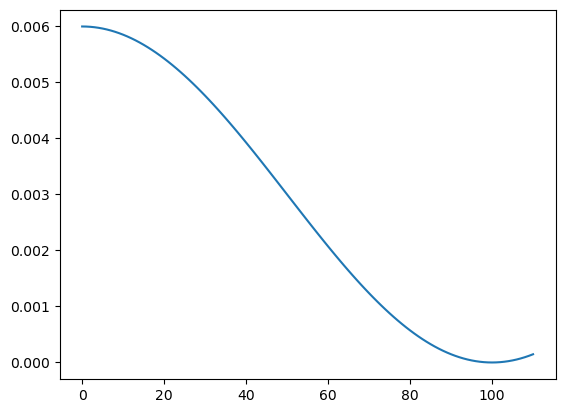

In [36]:
sched_lrs(sched, 110)

<mark> Above is an example of how to investigate (in a notebook) how an object behaves, what's in it, etc.
We always want to do this when using an API we are not familiar with, to learn about the stuff we work with.
See what's in it, see what they do, run it independently, plot, etc. .
We have to be good at exploring them and learning about them.
    </mark>

### Scheduler callbacks

A scheduler callback is something we're going to pass in the scheduling callable.
When we create the scheduler we have to pass in the optimizer to schedule.
`before_fit` is the point at which we have an Optimizer, we will create the scheduling object `schedo`.
The scheduling object we create by passing the optimizer `learn.opt` into the scheduler callable.
Then when we do `step`, and if we're training we'll `schedo.step()`.

In [37]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

`after_batch` will call `step`, if we want the scheduler to update the learning rate every batch.
We could also have an Epoch scheduler callback which we'll see later.

In [38]:
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [39]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

To see what this schedule is doing we need a new `RecorderCB` callback to keep track of what's going on in the learner.
We're going to be passing in the name of the thing that we want to keep track of in each batch,
and a function which is going to be responsible for grabbing the thing that we want.

The function `_lr` (below) is going to grab from the `cb` Callback look up its param groups property
and grab the learning rate `lr`. 
The `pg` attribute came from? 
`before_fit` the `RecorderCB` is going to grab just the first parameter group,
We've got to pick some parameter group to track so we'll just grab the first one.

We're going to create a dictionary `.recs` of all the things that we're recording.
So we'll get all the names (in this case just lr).
Initially `.recs` is going to be an empty list.
Then `after_batch` we'll go through each of the items in that dictionary (here just LR).
`lr` is the key and `_lr` function is the value.

And we will append to that list, call that method/function or callable and pass in this callback.
and that's why `_lr` is going to get the Callback.

In [40]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [41]:
def _lr(cb): return cb.pg['lr']

In [42]:
len(dls.train)

59

We have a whole bunch of dictionary of results in `.recs[k]` of these functions after each batch during training.
We'll just go through and plot them all, and lets see what it looks like.
Let's create a cosine annealing callable.
We're going to have to use a partial to say that this callable is going to have `T_Max=tmax`.
`tmax` is 3 times however many batches we have in our data loader `len(dls.train)`, because we're going to do 3 epochs.

In [43]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

We set it running and we're passing in the batch scheduler with the scheduler callable.
We're also going to pass in our recorder callback, saying we want to track the learning rate using the `_lr` function.
And we call `fit()`, and accuracy is getting close to .90 now in only three epochs which is impressive.

accuracy,loss,epoch,train
0.805,0.528,0,train
0.848,0.407,0,eval
0.875,0.344,1,train
0.873,0.356,1,eval
0.892,0.297,2,train
0.877,0.340,2,eval


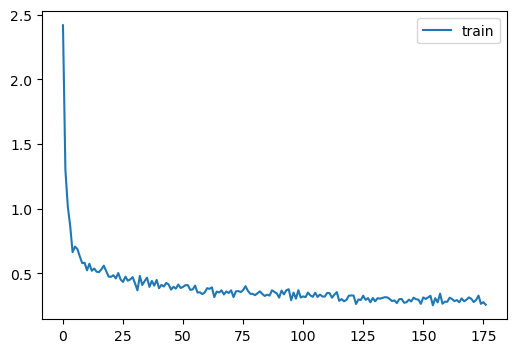

In [44]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

We then call `rec.plot`, to plots the learning rate.

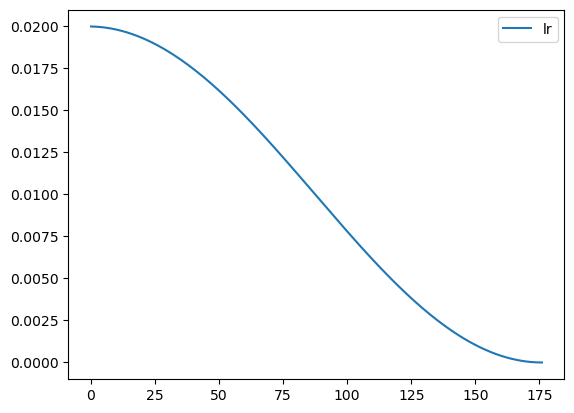

In [45]:
rec.plot()

We can do the same thing but replace `after_batch` with `after_epoch` and this will now
become a scheduler which steps at the *end of each epoch* rather than at the end of each batch.
We can do the same thing using an Epoch scheduler, with `T_Max = 3` because we're only going to
be stepping 3 times, we're not stepping at the end of each batch, just at the end of each epoch.
Again trains and we can call `rec.plot` after it trains.

In [46]:
#export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self.step(learn)

accuracy,loss,epoch,train
0.816,0.508,0,train
0.860,0.384,0,eval
0.880,0.328,1,train
0.878,0.338,1,eval
0.899,0.275,2,train
0.885,0.314,2,eval


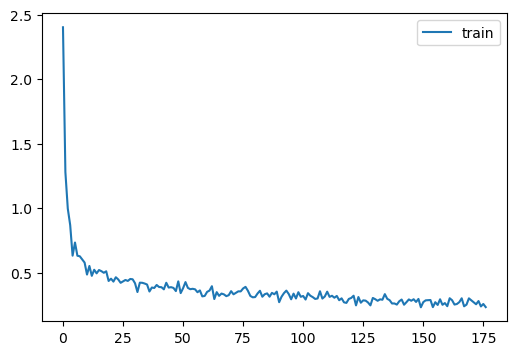

In [47]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

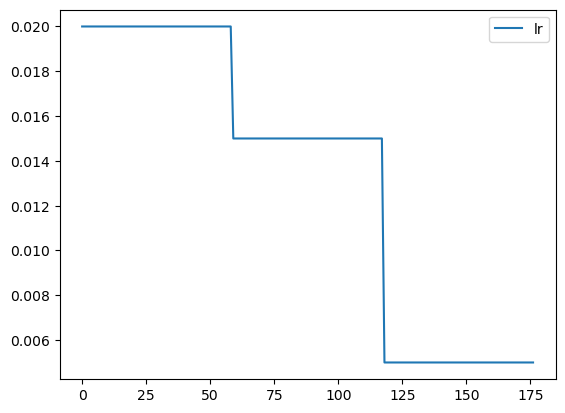

In [48]:
rec.plot()

And it's just stepping three times as expected.

### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

We can replace our scheduler with Pytorch one cycle learning rate scheduler `OneCycleLr`.
We make it a batch scheduler, and we're going to train 5 epochs, and get .90.

In [49]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.761,0.670,0,train
0.799,0.669,0,eval
0.858,0.386,1,train
0.861,0.401,1,eval
0.881,0.323,2,train
0.878,0.334,2,eval
0.898,0.272,3,train
0.892,0.301,3,eval
0.915,0.230,4,train
0.896,0.287,4,eval


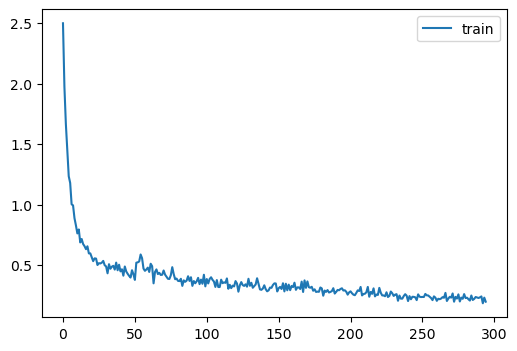

In [50]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Below are the plots. 2 things are being plotted because we passed into the recorder callback 
a plot of learning rates and also a plot of momentums.
`rec = RecorderCB(lr=_lr, mom=_beta1)`
Momentums its going to grab from `cp.pg['betas'][0]`.
For Adam it's called beta0 and beta1 is momentum of the gradients squared.
The one cycle is starting the learning rate very low, and going up to high and then down again.
But the momentum is starting high and then going down and then up again.

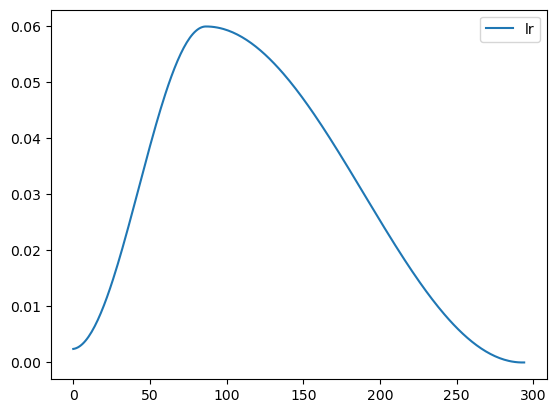

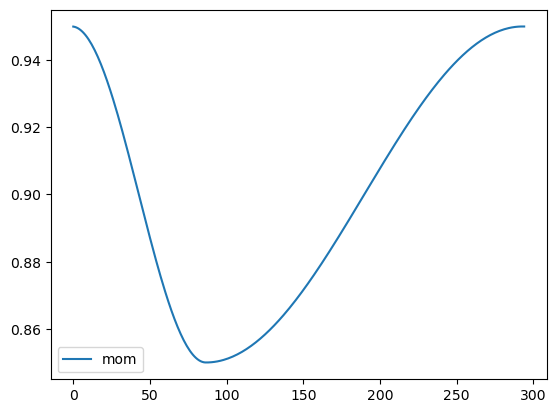

In [51]:
rec.plot()

Starting out at a low learning rate is important if you have a not perfectly initialized model 
(which almost everybody almost always does).
There are a lot of models that get more complicated and eventually 
people figure out how to initialize more complex models properly.

We do a a warm up if the  Network is not initialized correctly.
Starting at a very low learning rate means it's not going to jump off
way outside the area where the weights even make sense.
Then gradually increase them as the weights move into a part of the space that does make sense. 
And then during that time, while we have low learning rates, 
if they keep moving in the same direction, then with this very high momentum they'll move more and more quickly.

But if they keep moving in different directions, the momentum is going to look at the underlying Direction
they're moving.
Once we got to a good part of the weight space we can use a high LR, 
and with a very high learning rate you wouldn't want so much momentum.

The excel spreadsheet did this automatically, as you get closer to the optimal you generally want
to decrease the learning rate and since we're decreasing it again we can increase the momentum.
Starting from random weights we've got a pretty good accuracy on fashion mnist 
with a standard convolutional neural network, everything built from scratch.

Starting out at a low learning rate is important if you have a not perfectly initialized model 
(which almost everybody almost always does).
There are a lot of models that get more complicated and eventually 
people figure out how to initialize more complex models properly.
For example a paper in 2019 "Fixup initialization: Residual Learning without Normalization"
figured out how to initialize resnets properly.
They discovered when they did that they did not need batchNorm and they could train
networks of 10000 layers and get state-of-the-art performance.
There's actually been something similar for Transformers called T-Fixup.
It is difficult to initialize models correctly.
Most people fail to ost people fail to realize that they don't need tricks warmup and batchNorm 
if they do initialize them correctly.
T-Fixup explicitly looks at the difference between no warm-up versus with warm-up 
with their correct initialization versus with normal initialization.
Their pictures are log scale histograms of gradients they're very similar to the colorful Dimension plots.
ColorDimension are easier to read but *T-Fixup* plots are prettier.

## Export -

In [52]:
import nbdev; nbdev.nbdev_export()